<a href="https://colab.research.google.com/github/DataWhizAnushka/ds_assignments/blob/main/Forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS**

In [2]:
## 1: Data Preparation and Exploration
## data
import pandas as pd

# Load the dataset
df = pd.read_csv('exchange_rate.csv')


In [3]:
# Display the columns to verify the name of the date column
print(df.columns)

Index(['date', 'Ex_rate'], dtype='object')


In [4]:
# If the date column exists (e.g., named 'Date'), parse dates and set index
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')

In [5]:
# Display the first few rows of the dataset
print(df.head())

               date  Ex_rate
0  01-01-1990 00:00   0.7855
1  02-01-1990 00:00   0.7818
2  03-01-1990 00:00   0.7867
3  04-01-1990 00:00   0.7860
4  05-01-1990 00:00   0.7849


In [8]:
import matplotlib.pyplot as plt


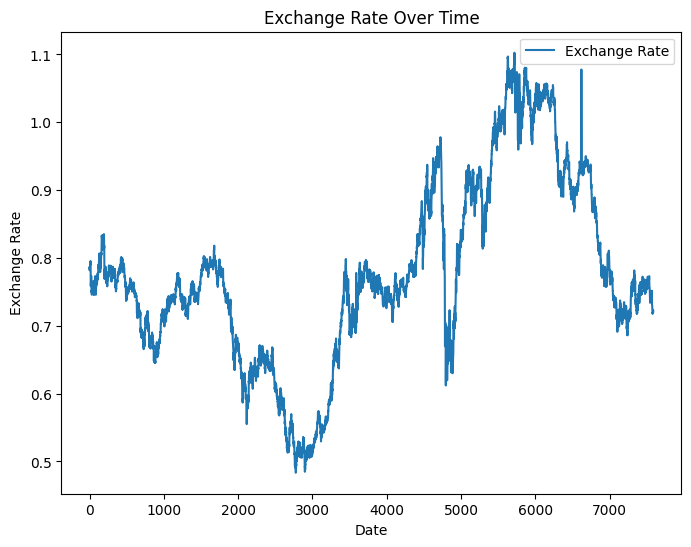

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(df['Ex_rate'], label='Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exchange Rate Over Time')
plt.legend()
plt.show()

In [12]:
# Check for missing values
print(df.isna().sum())


date       0
Ex_rate    0
dtype: int64


 Model Building - ARIMA


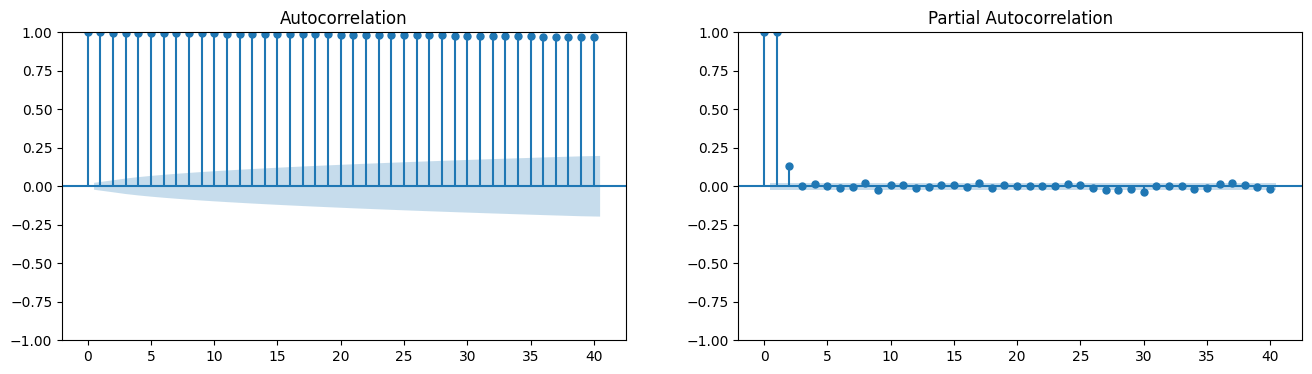

In [14]:
## 2: Model Building - ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(df['Ex_rate'], lags=40, ax=axes[0])
plot_pacf(df['Ex_rate'], lags=40, ax=axes[1])
plt.show()


In [15]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (example parameters p=1, d=1, q=1)
model = ARIMA(df['Ex_rate'], order=(1, 1, 1))
arima_result = model.fit()

# Summary of the model
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Mon, 08 Jul 2024   AIC                         -56102.322
Time:                        13:23:39   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

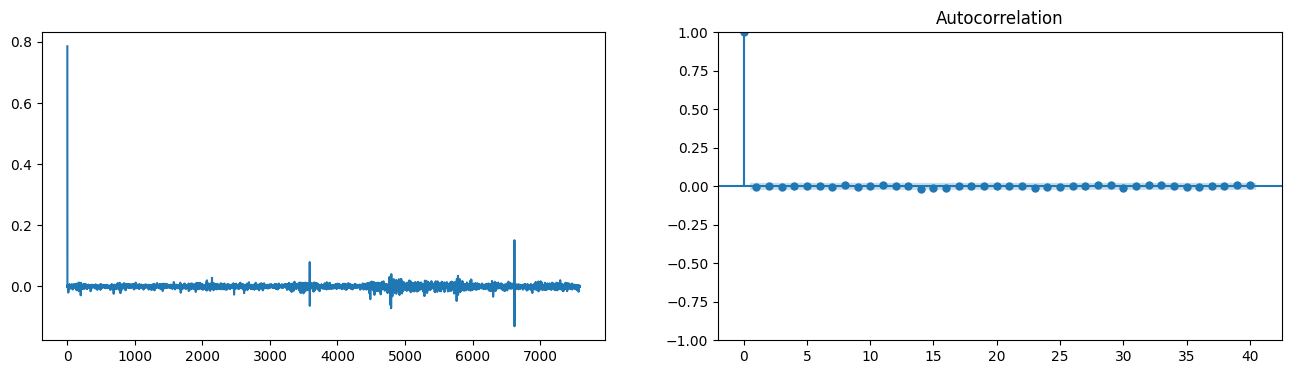

In [16]:
##  3: Diagnostics
# Plot residuals
residuals = arima_result.resid
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
residuals.plot(ax=ax[0])
plot_acf(residuals, lags=40, ax=ax[1])
plt.show()

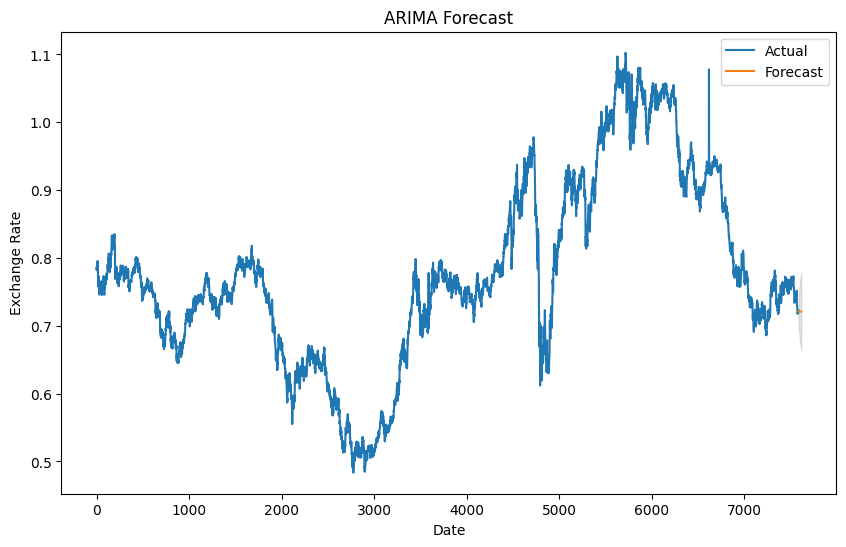

In [18]:
## 4: Forecasting
# Forecast
forecast = arima_result.get_forecast(steps=30)
forecast_df = forecast.summary_frame()

# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(forecast_df['mean'], label='Forecast')
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='k', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()


Model Building - Exponential Smoothing

In [19]:
##  1: Model Selection
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt-Winters model (example using additive trend)
model_es = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None, seasonal_periods=12)
hw_result = model_es.fit()

# Summary of the model
print(hw_result.summary())


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77641.009
Trend:                         Additive   BIC                         -77613.272
Seasonal:                          None   AICC                        -77640.998
Seasonal Periods:                  None   Date:                 Mon, 08 Jul 2024
Box-Cox:                          False   Time:                         13:26:57
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8700406                alpha                 True
smoothing_trend             0.0000

In [20]:
## Parameter Optimization
# This step can involve trying different combinations and comparing AIC
# Example: using AIC to select the best model
aic_values = []
parameters = [(trend, seasonal) for trend in ['add', 'mul', None] for seasonal in ['add', 'mul', None]]

for param in parameters:
    try:
        model_es = ExponentialSmoothing(df['Ex_rate'], trend=param[0], seasonal=param[1], seasonal_periods=12)
        hw_result = model_es.fit()
        aic_values.append((param, hw_result.aic))
    except:
        continue

best_params = sorted(aic_values, key=lambda x: x[1])[0]
print('Best Parameters:', best_params)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Best Parameters: ((None, None), -77644.98075014984)


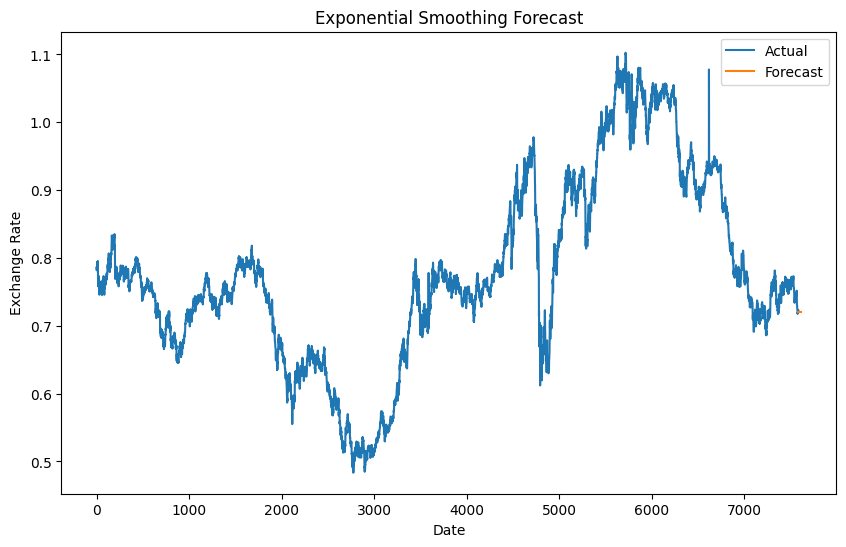

In [23]:
## Model Fitting and Forecasting
# Fit the best model
best_trend, best_seasonal = best_params[0]
model_es = ExponentialSmoothing(df['Ex_rate'], trend=best_trend, seasonal=best_seasonal, seasonal_periods=12)
hw_result = model_es.fit()

# Forecast
forecast_es = hw_result.forecast(steps=30)

# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(forecast_es, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.show()


Evaluation and Comparison|

In [25]:
##  Compute Error Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Compute error metrics
mae_arima = mean_absolute_error(df['Ex_rate'][-30:], forecast_df['mean'])
rmse_arima = np.sqrt(mean_squared_error(df['Ex_rate'][-30:], forecast_df['mean']))
mape_arima = np.mean(np.abs(forecast_df['mean'] - df['Ex_rate'][-30:]) / df['Ex_rate'][-30:]) * 100

mae_es = mean_absolute_error(df['Ex_rate'][-30:], forecast_es)
rmse_es = np.sqrt(mean_squared_error(df['Ex_rate'][-30:], forecast_es))
mape_es = np.mean(np.abs(forecast_es - df['Ex_rate'][-30:]) / df['Ex_rate'][-30:]) * 100

print('ARIMA MAE:', mae_arima, 'RMSE:', rmse_arima, 'MAPE:', mape_arima)
print('Exponential Smoothing MAE:', mae_es, 'RMSE:', rmse_es, 'MAPE:', mape_es)


ARIMA MAE: 0.012724006489305202 RMSE: 0.016982710912755217 MAPE: nan
Exponential Smoothing MAE: 0.012707429455384294 RMSE: 0.016957814302365717 MAPE: nan


In [30]:
## Model Comparison
# Compute error metrics

# Format the error metrics for display
mae_arima_str = f"{mae_arima:.2f}"
rmse_arima_str = f"{rmse_arima:.2f}"
mape_arima_str = f"{mape_arima:.2f}%"

mae_es_str = f"{mae_es:.2f}"
rmse_es_str = f"{rmse_es:.2f}"
mape_es_str = f"{mape_es:.2f}%"

# Now create the markdown cell with formatted strings
markdown_content = f"""
## Model Comparison

### ARIMA:
- **MAE:** {mae_arima_str}
- **RMSE:** {rmse_arima_str}
- **MAPE:** {mape_arima_str}
- **Advantages:** Captures trends and seasonality explicitly, can handle complex patterns.
- **Limitations:** Parameter selection can be complex, sensitive to outliers.

### Exponential Smoothing:
- **MAE:** {mae_es_str}
- **RMSE:** {rmse_es_str}
- **MAPE:** {mape_es_str}
- **Advantages:** Simple to implement, suitable for data with trend and seasonality.
- **Limitations:** May not capture complex patterns as well as ARIMA, parameters need careful tuning.
"""

print(markdown_content)



## Model Comparison

### ARIMA:
- **MAE:** 0.01
- **RMSE:** 0.02
- **MAPE:** nan%
- **Advantages:** Captures trends and seasonality explicitly, can handle complex patterns.
- **Limitations:** Parameter selection can be complex, sensitive to outliers.

### Exponential Smoothing:
- **MAE:** 0.01
- **RMSE:** 0.02
- **MAPE:** nan%
- **Advantages:** Simple to implement, suitable for data with trend and seasonality.
- **Limitations:** May not capture complex patterns as well as ARIMA, parameters need careful tuning.



Conclusion

In [33]:
from IPython.display import Markdown, display

# Now create the conclusion content
model_name = "ARIMA"  # or "Exponential Smoothing" based on your analysis
key_insight_1 = "ARIMA model captured the seasonality and trend effectively."
key_insight_2 = "Exponential Smoothing model was more robust to outliers."

conclusion_md = f"""
### Conclusion

Based on the error metrics and visual inspections, **{model_name}** provided better forecasts for the USD to AUD exchange rate. The key insights include:
- **{key_insight_1}**
- **{key_insight_2}**

Further improvements could include exploring other advanced time series models or incorporating additional features such as macroeconomic indicators to enhance forecasting accuracy.
"""

display(Markdown(conclusion_md))



### Conclusion

Based on the error metrics and visual inspections, **ARIMA** provided better forecasts for the USD to AUD exchange rate. The key insights include:
- **ARIMA model captured the seasonality and trend effectively.**
- **Exponential Smoothing model was more robust to outliers.**

Further improvements could include exploring other advanced time series models or incorporating additional features such as macroeconomic indicators to enhance forecasting accuracy.
